In [ ]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (23.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [ ]:
!pip install pytesseract
from matplotlib import pyplot as plt
import cv2
import pytesseract
import numpy as np
from google.colab.patches import cv2_imshow

* look into pytesseract
* why would cca even be needed
* test with more variatoins of images
* apply perspective transform
* other preprocessing if it helps





In [ ]:
img_path = "12.jpg"
# img_path = "dataset-1.jpg"
# img_path = "dataset-3.jpg"
# img_path = "dataset-1.jpg"

number_plate = cv2.imread(img_path)
image = cv2.cvtColor(number_plate, cv2.COLOR_BGR2RGB)
rgb = image.copy()
plt.imshow(rgb)
plt.title("Original image")

error: ignored

# perspective transformation

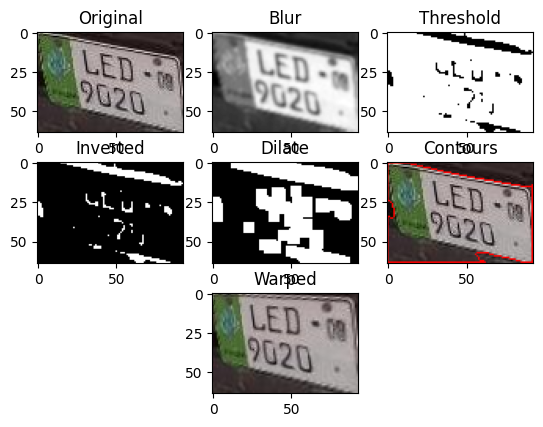

In [ ]:
def order_points(pts):
    # Step 1: Find centre of object
    center = np.mean(pts)

    # Step 2: Move coordinate system to centre of object
    shifted = pts - center

    # Step #3: Find angles subtended from centroid to each corner point
    theta = np.arctan2(shifted[:, 0], shifted[:, 1])

    # Step #4: Return vertices ordered by theta
    ind = np.argsort(theta)
    return pts[ind]


def getContours(img, orig):  # Change - pass the original image too
    biggest = np.array([])
    maxArea = 0
    imgContour = orig.copy()  # Make a copy of the original image to return
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    index = None
    for i, cnt in enumerate(contours):  # Change - also provide index
        area = cv2.contourArea(cnt)
        if area > 500:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt,0.02*peri, True)
            # print(len(approx))
            if area > maxArea and len(approx) == 4:
                biggest = approx
                maxArea = area
                index = i  # Also save index to contour

    warped = None  # Stores the warped license plate image
    if index is not None: # Draw the biggest contour on the image
        cv2.drawContours(imgContour, contours, index, (255, 0, 0), 1)

        src = np.squeeze(biggest).astype(np.float32) # Source points
        height = image.shape[0]
        width = image.shape[1]
        # Destination points
        dst = np.float32([[0, 0], [0, height - 1], [width - 1, 0], [width - 1, height - 1]])

        # Order the points correctly
        biggest = order_points(src)
        dst = order_points(dst)

        # Get the perspective transform
        M = cv2.getPerspectiveTransform(src, dst)

        # Warp the image
        img_shape = (width, height)
        warped = cv2.warpPerspective(orig, M, img_shape, flags=cv2.INTER_LINEAR)

    return biggest, imgContour, warped  # Change - also return drawn image

kernel = np.ones((3,3))

imgGray = cv2.cvtColor(number_plate, cv2.COLOR_BGR2GRAY)
imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)
imgThres = cv2.adaptiveThreshold(imgBlur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,31,34)
imgInv = cv2.bitwise_not(imgThres)
imgDial = cv2.dilate(imgInv,kernel,iterations=3)
biggest, imgContour, warped = getContours(imgThres, number_plate)  # Change
titles = ['Original', 'Blur',  'Threshold', 'Inverted', 'Dilate','Contours', 'Warped']  # Change - also show warped image
images = [image[...,::-1],  imgBlur, imgThres, imgInv, imgDial, imgContour, warped]  # Change

# Change - Also show contour drawn image + warped image
for i in range(5):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

plt.subplot(3, 3, 6)
plt.imshow(images[-2])
plt.title(titles[-2])

plt.subplot(3, 3, 8)
plt.imshow(images[-1])
plt.title(titles[-1])

plt.show()

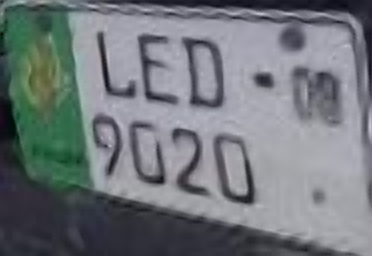

In [ ]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()
path = "ESPCN_x4.pb"
sr.readModel(path)
sr.setModel("espcn", 4) # set the model by passing the value and the upsampling ratio
upscaled_img = sr.upsample(warped) # upscale the input image
cv2_imshow(upscaled_img)

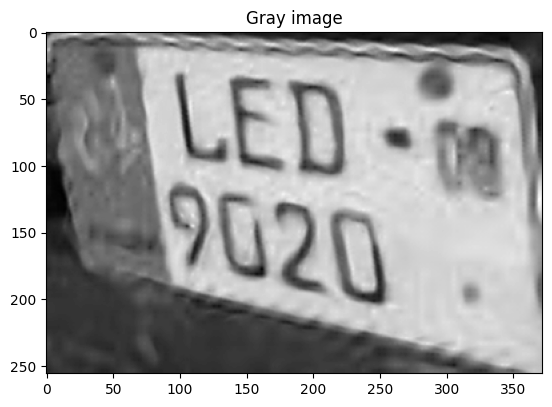

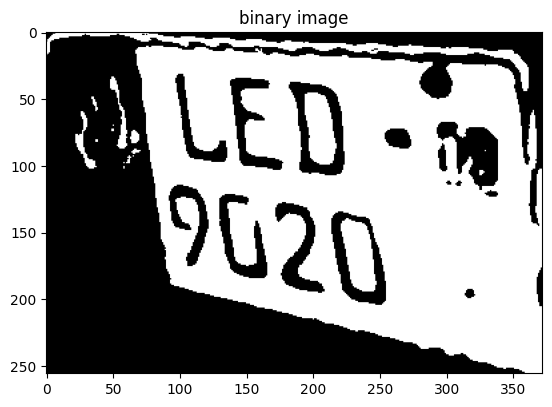

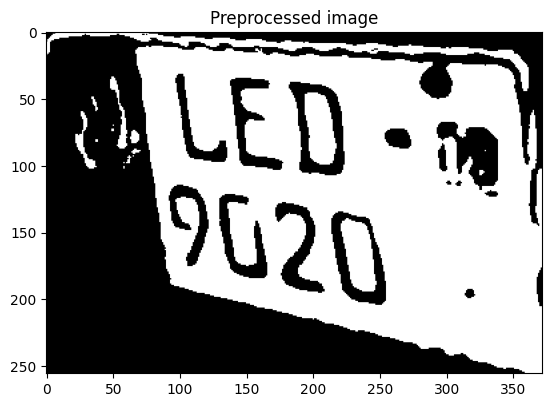

In [ ]:
# preprocessing for better recognition of characters
def preprocessing_for_ocr(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.imshow(gray,cmap='gray')
    plt.title("Gray image")
    plt.show()
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.imshow(binary,cmap='gray')
    plt.title("binary image")
    plt.show()
    return binary

preprocessed = preprocessing_for_ocr(upscaled_img)

plt.imshow(preprocessed,cmap='gray')
plt.title("Preprocessed image")
plt.show()



Recognized Characters: LED49
WW


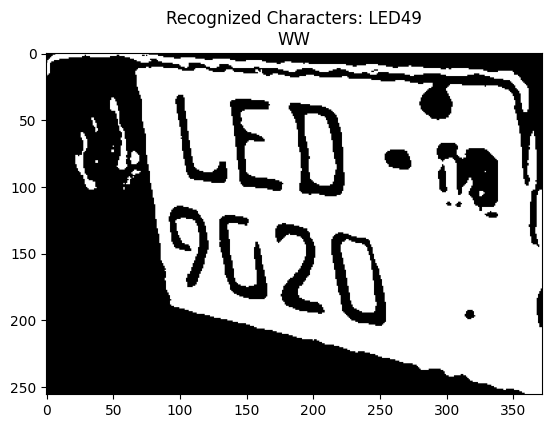

In [ ]:
# OCR (Tesseract) for character recognition
tesseract_config = "--psm 6 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
recognized_text = pytesseract.image_to_string(preprocessed, config=tesseract_config).strip()

print(f"Recognized Characters: {recognized_text}")

plt.imshow(preprocessed, cmap="gray")
plt.title(f"Recognized Characters: {recognized_text}")
plt.show()

# Using EASY OCR

In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 15.4 MB/s eta 0:00:00


In [ ]:
import easyocr

# using easy ocr
def perform_easyocr(ocr_reader, img):
    """Performs OCR using EasyOCR and returns recognized text"""
    results = ocr_reader.readtext(img)
    recognized_text = ' '.join(result[1] for result in results)
    return recognized_text

ocr_reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

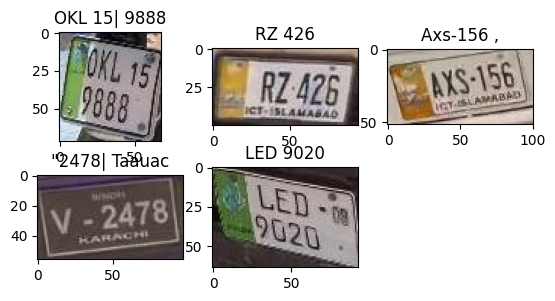

In [ ]:
plates = ["1.jpg", "4.jpg", "7.jpg", "11.jpg", "12.jpg"]
recognized_text = []
n_plates = []
for i in plates:
  number_plate = cv2.imread(i)
  n_plates.append(number_plate)
  recognized_text.append(perform_easyocr(ocr_reader, number_plate))


for i in range(5):
    plt.subplot(3, 3, i+1)
    plt.imshow(n_plates[i], cmap='gray')
    plt.title(recognized_text[i])

plt.show()